In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    

import collocation
from collocation import chebyshev_nodes_second_kind_jax, compute_weights, lagrange_derivative, lagrange_basis

import importlib

In [31]:
# set interpolating node locations
xi = jnp.linspace(-1, 1, 5) 
weights = compute_weights(xi)

# evaluate at more points
x = jnp.linspace(-1, 1, 100) 
basis = lagrange_basis(xi, x)
derivatives = lagrange_derivative(xi, weights)

### 5 basis cases

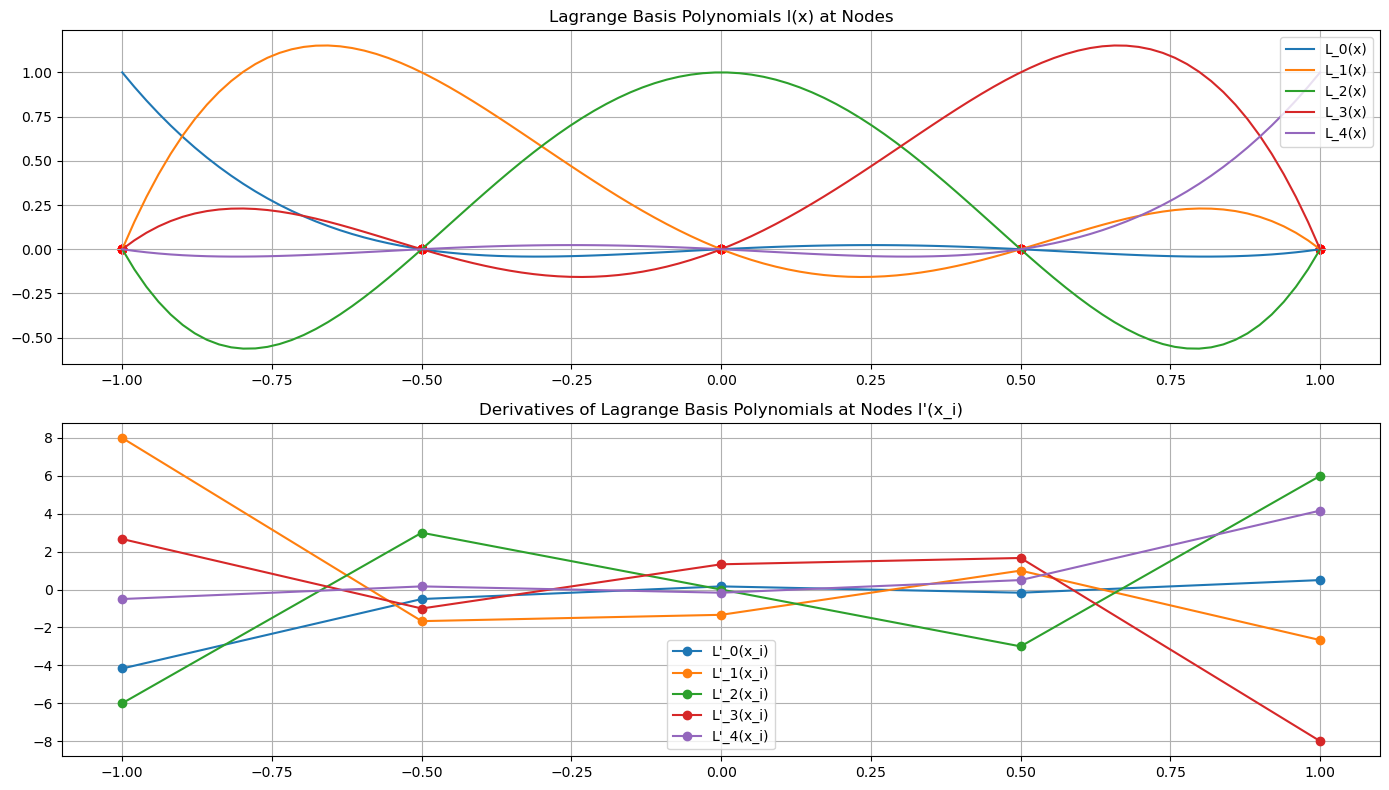

In [32]:
plt.figure(figsize=(14, 8))
for i in range(len(xi)):
    plt.subplot(2, 1, 1)
    plt.plot(x, basis[i, :], label=f'L_{i}(x)')
    plt.scatter(xi, jnp.zeros_like(xi), color='red')  # Nodes
    plt.title('Lagrange Basis Polynomials l(x) at Nodes')
    plt.grid()
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(xi, derivatives[:, i], label=f'L\'_{i}(x_i)', marker='o')
    plt.title("Derivatives of Lagrange Basis Polynomials at Nodes l'(x_i)")
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

# Chebyshev 

In [ ]:
# rerun imports
import data_generation
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

importlib.reload(collocation)
compute_weights = collocation.compute_weights
lagrange_derivative = collocation.lagrange_derivative

In [753]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 64
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
start_time, end_time = a, b
spacing_type = "chebyshev"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

In [754]:
weights = compute_weights(t_ho)
derivatives = lagrange_derivative(t_ho, weights)

dy_dt_0 = []
dy_dt_1 = []

for i in range(len(derivatives)):
    dy_dt_0.append(jnp.dot(derivatives[i], y_ho[:,0]).item())
    dy_dt_1.append(jnp.dot(derivatives[i], y_ho[:,1]).item())

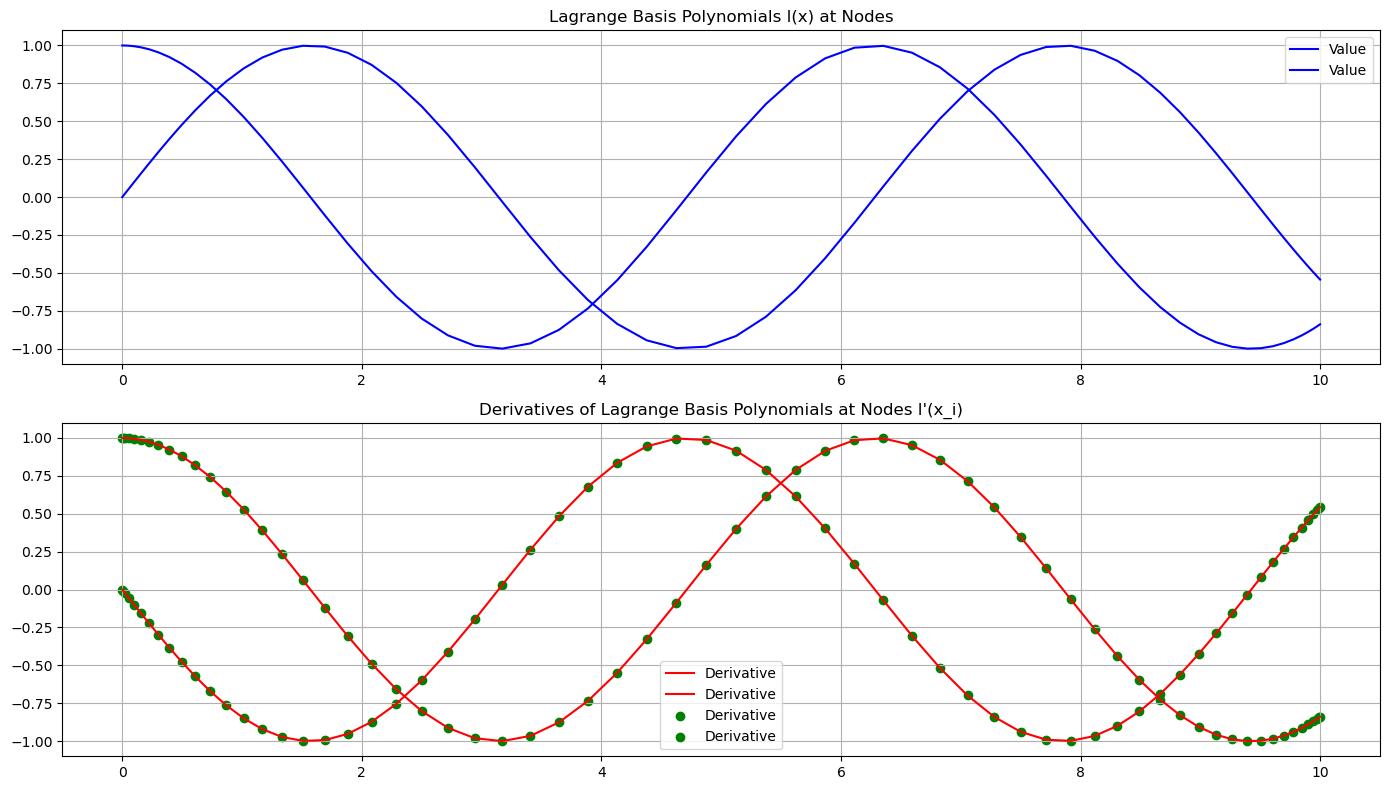

In [755]:
L, R = 0, -1

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t_ho, y_ho, color='blue', label=f'Value')
plt.title('Lagrange Basis Polynomials l(x) at Nodes')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_ho, true_derivatives_ho, color='red', label = 'Derivative')
plt.scatter(t_ho[:], dy_dt_0[:], color='green', label = 'Derivative')
plt.scatter(t_ho[:], dy_dt_1[:], color='green', label = 'Derivative')
#plt.scatter(t_ho, results[:,0], color='green', label = 'Derivative')
plt.title("Derivatives of Lagrange Basis Polynomials at Nodes l'(x_i)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### Chebyshev erros

In [756]:
errors = {}

In [757]:
error_norm = np.linalg.norm(true_derivatives_ho[:,0] - np.array(dy_dt_0))*0.5
error_norm += np.linalg.norm(true_derivatives_ho[:,1] - np.array(dy_dt_1))*0.5
print("Error Norm:", error_norm)

Error Norm: 4.1509155355744796e-07


In [758]:
error_norm = np.linalg.norm(true_derivatives_ho[:,0] - np.array(dy_dt_0))*0.5
error_norm += np.linalg.norm(true_derivatives_ho[:,1] - np.array(dy_dt_1))*0.5
print("Error Norm:", error_norm)

errors['chebyshev'] = error_norm

Error Norm: 4.1509155355744796e-07


# legendre_radau

In [759]:
from numpy.polynomial.legendre import leggauss

In [760]:
def compute_weights(xi):
    """
    Compute the weights for each node in the array of nodes xi used in Lagrange interpolation.

    Parameters:
    xi (array_like): The nodes at which the weights are to be computed.

    Returns:
    array_like: An array of weights corresponding to each node.
    """
    xi = jnp.array(xi)
    n = len(xi)
    weights = jnp.zeros(n)

    for j in range(n):
        # exclude the j-th term and compute the product of (x_j - x_m) for all m != j
        terms = xi[j] - jnp.delete(xi, j)
        product = jnp.prod(terms)
        weights = weights.at[j].set(1.0 / product)

    return weights

In [761]:
import numpy as np
import jax.numpy as jnp

def legendre_radau_nodes_weights(N, a=-1, b=1):
    """
    Compute the nodes and weights for the Legendre-Gauss-Radau quadrature.
    
    Parameters:
    N (int): Number of nodes (excluding the fixed endpoint).
    a (float): Lower bound of the interval. Default is -1.
    b (float): Upper bound of the interval. Default is 1.
    
    Returns:
    nodes (array_like): Legendre-Gauss-Radau nodes in the interval [a, b].
    weights (array_like): Weights corresponding to the Legendre-Gauss-Radau nodes.
    """
    
    nodes = np.zeros(N+1)
    
    P_N = np.polynomial.legendre.Legendre.basis(N)
    P_N_plus_1 = np.polynomial.legendre.Legendre.basis(N+1)
    q = P_N + P_N_plus_1
    # LGR quadrature nodes are the roots of the polynomial q
    nodes = q.roots()
    
    nodes = jnp.sort(jnp.array(nodes))
    
    # scale nodes from [-1, 1] to [a, b]
    scaled_nodes = 0.5 * (b - a) * nodes + 0.5 * (a + b)
    
    coeffs = np.zeros(N + 1)
    coeffs[-1] = 1 
    
    # REUSING FORMULA FOR LAGRANGE POLYNOMIALS WEIGHTS
    weights = compute_weights(scaled_nodes) 
    
    return scaled_nodes, weights

def lagrange_radau_derivative_matrix(xi, weights):
    # BARYCENTRIC FORM DERIVATIVES
    """
    Compute the derivative matrix for Lagrange-Radau polynomials at nodes xi.
    
    Parameters:
    xi (array_like): Nodes at which the Lagrange-Radau basis polynomials are defined.
    weights (array_like): Weights for each node in the array of nodes xi.
    
    Returns:
    array_like: Derivative matrix of the Lagrange-Radau basis polynomials at the nodes xi.
    """
    n = len(xi)
    D = jnp.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                D = D.at[i, j].set(weights[j] / weights[i] / (xi[i] - xi[j]))
    
    for i in range(n):
        D = D.at[i, i].set(-jnp.sum(D[i, :i]) - jnp.sum(D[i, i+1:]))
    
    return D


In [685]:
N = 100
a, b = -1, 1  # New interval [a, b]
xi, weights = legendre_radau_nodes_weights(N, a, b)
xi, weights = xi[1:], weights[1:]  # Exclude the fixed endpoint
derivative_matrix = lagrange_radau_derivative_matrix(xi, weights)

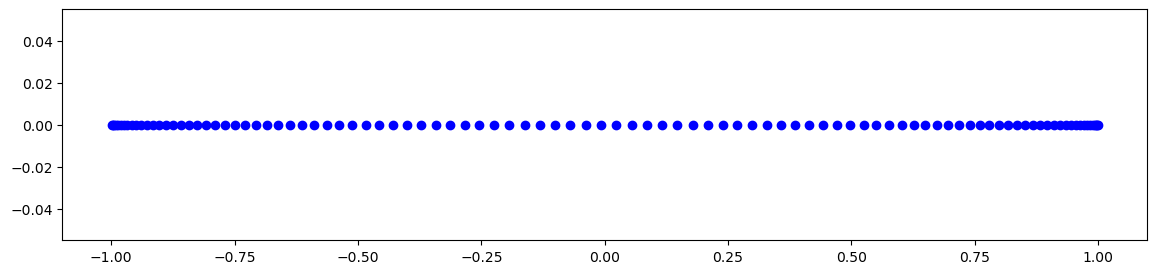

In [686]:
plt.figure(figsize=(14, 3))
plt.scatter(xi, np.zeros_like(xi), color='blue', label=f'Value')
plt.show()

In [687]:
dy_dt_0 = []
dy_dt_1 = []

for i in range(0, len(derivative_matrix)):
    dy_dt_0.append(jnp.dot(derivative_matrix[:,:][i], y_ho[:,0]).item())
    dy_dt_1.append(jnp.dot(derivative_matrix[:,:][i], y_ho[:,1]).item())

TypeError: dot_general requires contracting dimensions to have the same shape, got (100,) and (64,).

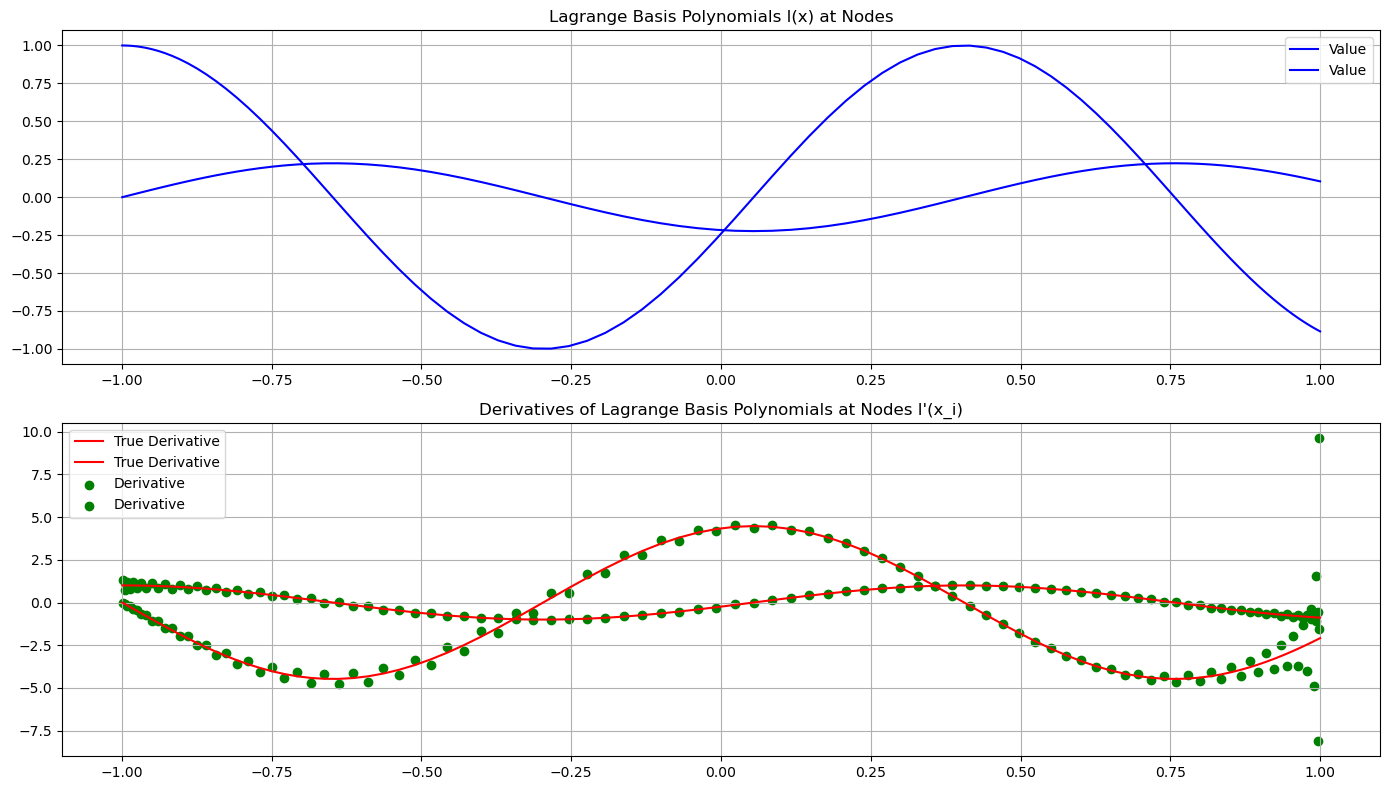

In [ ]:
k = 1
L, R = k, -k

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t_ho, y_ho, color='blue', label=f'Value')
plt.title('Lagrange Basis Polynomials l(x) at Nodes')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_ho, true_derivatives_ho, color='red', label = 'True Derivative')
plt.scatter(t_ho[L:R], dy_dt_1[L:R], color='green', label = 'Derivative')
plt.scatter(t_ho[L:R], dy_dt_0[L:R], color='green', label = 'Derivative')
plt.title("Derivatives of Lagrange Basis Polynomials at Nodes l'(x_i)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

---
---

In [688]:
import numpy as np
from scipy.special import eval_legendre

def compute_Lq_minus_1(q, nodes):
    # Compute the (q-1)-th Legendre polynomial values at the given nodes
    Lq_minus_1_values = eval_legendre(q - 1, nodes)
    return Lq_minus_1_values

def compute_differentiation_matrix(q, nodes):
    Lq_minus_1_values = compute_Lq_minus_1(q, nodes)
    d_matrix = np.zeros((q, q))
    
    for i in range(q):
        for j in range(q):
            if i == 0 and j == 0:
                d_matrix[i, j] = -((q-1)*(q+1)) / 4
            elif i != j:
                d_matrix[i, j] = (Lq_minus_1_values[i] / Lq_minus_1_values[j]) * ((1 - nodes[j]) / (1 - nodes[i])) * (1 / (nodes[i] - nodes[j]))
            elif 1 <= i == j <= q - 1:
                d_matrix[i, j] = 1 / (2 * (1 - nodes[i]))
    
    return d_matrix


In [689]:
d_matrix = compute_differentiation_matrix(len(xi), xi)

In [544]:
dy_dt_0 = []
dy_dt_1 = []

for i in range(0, len(d_matrix)):
    dy_dt_0.append(jnp.dot(d_matrix[:,:][i], y_ho[:,0]).item())
    dy_dt_1.append(jnp.dot(d_matrix[:,:][i], y_ho[:,1]).item())

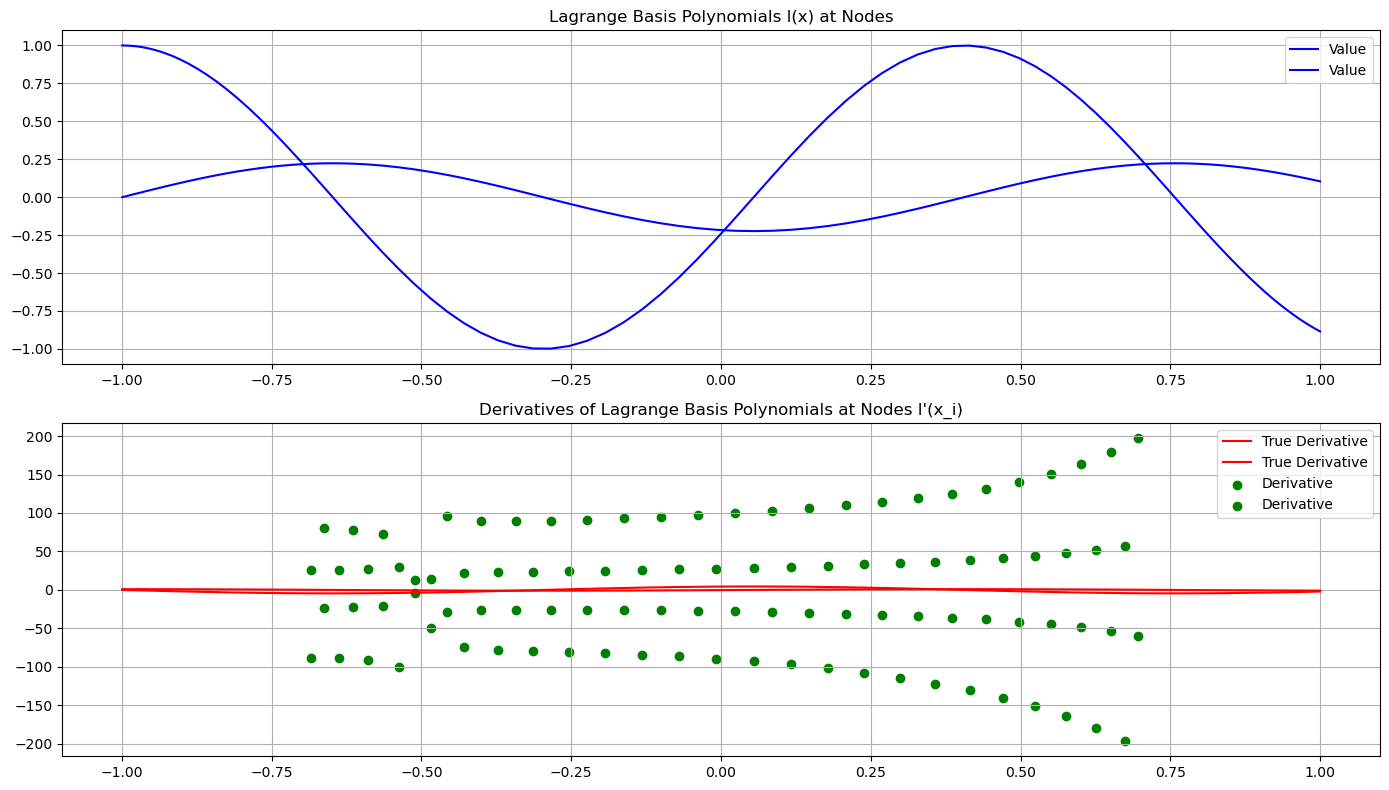

In [546]:
k = 25
L, R = k, -k

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t_ho, y_ho, color='blue', label=f'Value')
plt.title('Lagrange Basis Polynomials l(x) at Nodes')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_ho, true_derivatives_ho, color='red', label = 'True Derivative')
plt.scatter(t_ho[L:R], dy_dt_1[L:R], color='green', label = 'Derivative')
plt.scatter(t_ho[L:R], dy_dt_0[L:R], color='green', label = 'Derivative')
plt.title("Derivatives of Lagrange Basis Polynomials at Nodes l'(x_i)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

----

In [596]:
import numpy as np
from scipy.special import eval_legendre
from scipy.optimize import newton

def legendre_poly(n, x):
    # Evaluates the n-th Legendre polynomial at x using scipy.special.eval_legendre
    return eval_legendre(n, x)

def legendre_poly_deriv(n, x):
    # Evaluates the derivative of the n-th Legendre polynomial at x
    return n / (x**2 - 1) * (x * legendre_poly(n, x) - legendre_poly(n-1, x))

def generate_grl_nodes(q):
    # Include -1 as the first node
    nodes = [-1]
    
    # Find the remaining q-1 roots of the (q-1)-th Legendre polynomial using Newton's method
    for i in range(1, q):
        x0 = np.cos(np.pi * (i - 0.25) / (q - 0.5))  # Initial guess
        root = newton(lambda x: legendre_poly(q-1, x), x0, fprime=lambda x: legendre_poly_deriv(q-1, x))
        nodes.append(root)
    
    return np.sort(np.array(nodes))

def compute_Lq_minus_1(q, nodes):
    # Compute the (q-1)-th Legendre polynomial values at the given nodes
    Lq_minus_1_values = eval_legendre(q - 1, nodes)
    return Lq_minus_1_values

# Debugging print statements
def compute_differentiation_matrix(q, nodes):
    Lq_minus_1_values = compute_Lq_minus_1(q, nodes)
    d_matrix = np.zeros((q, q))
    
    for i in range(q):
        for j in range(q):
            if i == 0 and j == 0:
                d_matrix[i, j] = -((q-1)*(q+1)) / 4
            elif i != j:
                d_matrix[i, j] = (Lq_minus_1_values[i] / Lq_minus_1_values[j]) * ((1 - nodes[j]) / (1 - nodes[i])) * (1 / (nodes[i] - nodes[j]))
            elif 1 <= i == j <= q - 1:
                d_matrix[i, j] = 1 / (2 * (1 - nodes[i]))
    
    print("Lq_minus_1_values:", Lq_minus_1_values)
    return d_matrix


# Example usage
q = 64

# Generate Gauss-Radau-Legendre nodes
xi = generate_grl_nodes(q)

# Compute the differentiation matrix
d_matrix = compute_differentiation_matrix(len(xi), xi)

Lq_minus_1_values: [-1.00000000e+00  2.04617573e-13 -3.58740815e-15 -1.93178806e-14
 -4.16333634e-15  1.02279296e-14  5.24788546e-14 -2.39253062e-14
  5.09314813e-15 -7.03603842e-15 -2.48412402e-15  9.02056208e-16
  1.05471187e-15  1.15185639e-15 -9.15933995e-16 -1.24900090e-15
 -1.40165657e-15  4.16333634e-17  5.68989300e-16  6.38378239e-16
 -9.71445147e-17  1.30451205e-15 -4.71844785e-16  4.30211422e-16
 -7.63278329e-16  1.36002321e-15  2.77555756e-17  5.68989300e-16
  3.74700271e-16  1.66533454e-16  4.99600361e-16  5.82867088e-16
  7.83707701e-32 -1.80411242e-16  2.91433544e-16 -3.05311332e-16
 -3.19189120e-16  6.93889390e-17  5.55111512e-17  1.38777878e-17
  1.66533454e-16 -4.99600361e-16 -1.02695630e-15  2.35922393e-16
  3.74700271e-16 -1.38777878e-17 -2.63677968e-16  1.38777878e-16
  3.33066907e-16 -2.77555756e-16 -2.49800181e-16 -4.71844785e-16
 -7.91033905e-16  6.24500451e-16  2.77555756e-16  1.30451205e-15
 -5.07233144e-15  1.49255608e-14 -5.64409630e-14  1.72084569e-15
 -2.58

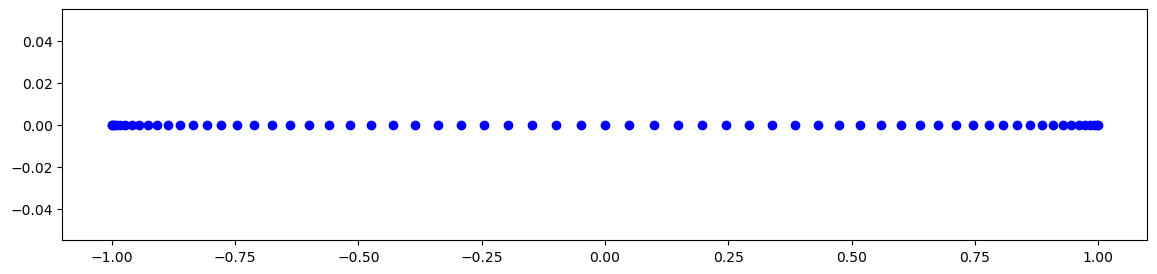

In [587]:
plt.figure(figsize=(14, 3))
plt.scatter(xi, np.zeros_like(xi), color='blue', label=f'Value')
plt.show()

In [588]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = q
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 20}
start_time, end_time = a, b
start_time, end_time = -1, 1
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state, t = xi)

In [589]:
derivative_matrix[0]

Array([-5.59657548e+02,  7.92632400e+02, -3.70189555e+02,  2.30688170e+02,
       -1.62522223e+02,  1.22773385e+02, -9.70685760e+01,  7.92617309e+01,
       -6.63011851e+01,  5.65086619e+01, -4.88894124e+01,  4.28189304e+01,
       -3.78868213e+01,  3.38131571e+01, -3.04009871e+01,  2.75080569e+01,
       -2.50292788e+01,  2.28854890e+01, -2.10160223e+01,  1.93736796e+01,
       -1.79212400e+01,  1.66289943e+01, -1.54729684e+01,  1.44336242e+01,
       -1.34948945e+01,  1.26434568e+01, -1.18681809e+01,  1.11597025e+01,
       -1.05100924e+01,  9.91259598e+00, -9.36142738e+00,  8.85160447e+00,
       -8.37881651e+00,  7.93931664e+00, -7.52983424e+00,  7.14750290e+00,
       -6.78980098e+00,  6.45450221e+00, -6.13963451e+00,  5.84344537e+00,
       -5.56437270e+00,  5.30102018e+00, -5.05213626e+00,  4.81659627e+00,
       -4.59338707e+00,  4.38159388e+00, -4.18038889e+00,  3.98902142e+00,
       -3.80680935e+00,  3.63313169e+00, -3.46742208e+00,  3.30916308e+00,
       -3.15788120e+00,  

In [590]:
d_matrix[0]

array([-1.02375000e+03,  6.81353539e+15, -7.36831143e+16, -5.55743977e+15,
       -1.38517110e+16,  3.50437858e+15,  4.64242449e+14, -7.35277217e+14,
        2.60481219e+15, -1.46919671e+15, -3.32590616e+15,  7.46996086e+15,
        5.29711437e+15,  4.07669160e+15, -4.35837615e+15, -2.74344691e+15,
       -2.11573440e+15,  6.20831437e+16,  3.98357620e+15,  3.13009243e+15,
       -1.82166733e+16,  1.20621513e+15, -2.97553427e+15,  2.92064104e+15,
       -1.47706172e+15,  7.45453375e+14,  3.29092686e+16,  1.44859419e+15,
        1.98748327e+15,  4.04443481e+15,  1.22019750e+15,  9.47085442e+14,
        6.37992965e+30, -2.51025430e+15,  1.40717334e+15, -1.21573174e+15,
       -1.05173043e+15,  4.37118234e+15,  4.93050389e+15,  1.77685898e+16,
        1.33154836e+15, -3.98251247e+14, -1.73389953e+14,  6.73438555e+14,
        3.77023699e+14, -9.01539021e+15, -4.18301032e+14,  6.96954727e+14,
        2.53107935e+14, -2.62863604e+14, -2.50702332e+14, -1.12832615e+14,
       -5.65681173e+13,  

In [591]:
y_ho.shape

(64, 2)

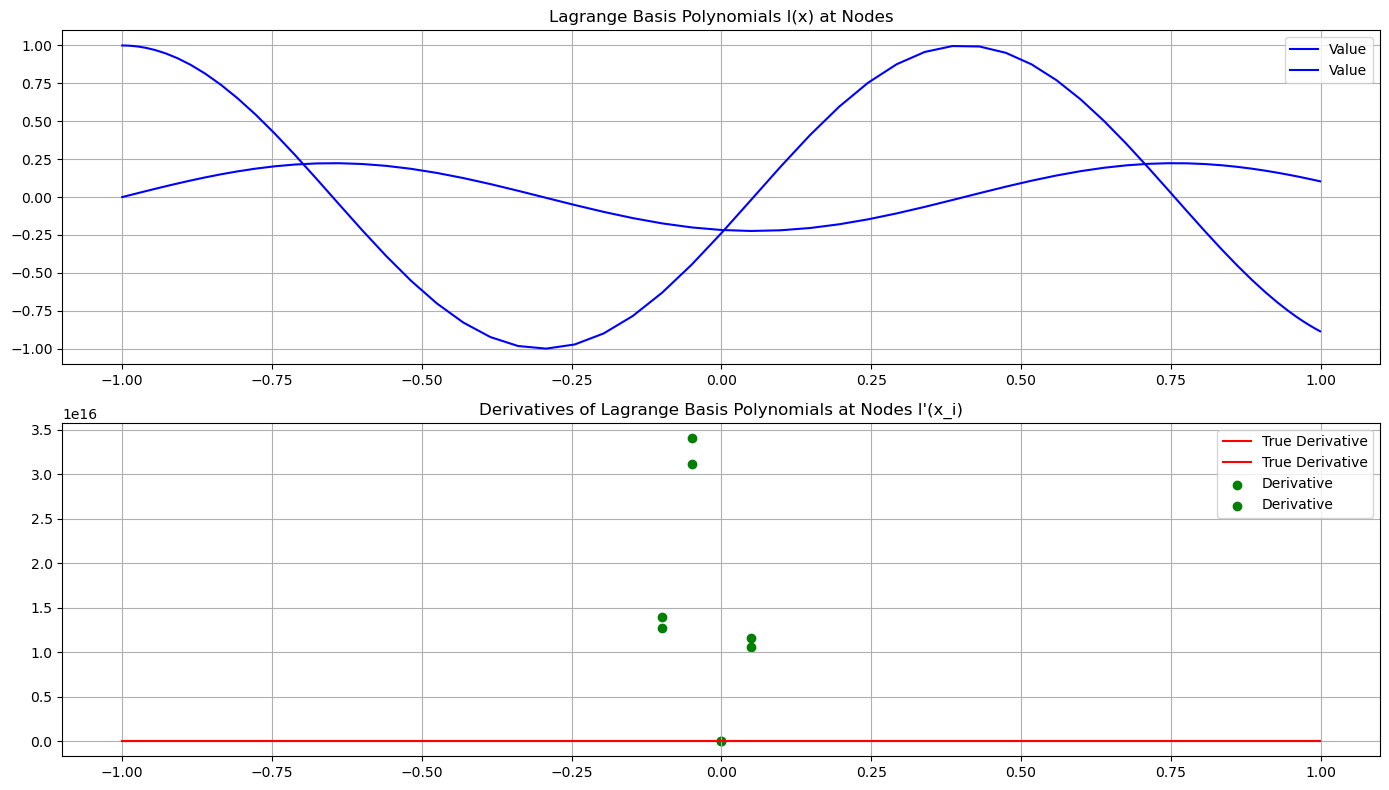

In [593]:
dy_dt_0 = []
dy_dt_1 = []

for i in range(0, len(d_matrix)):
    dy_dt_0.append(jnp.dot(d_matrix[:,:][i], y_ho[:,0]).item())
    dy_dt_1.append(jnp.dot(d_matrix[:,:][i], y_ho[:,1]).item())
    
    
k = 30
L, R = k, -k

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t_ho, y_ho, color='blue', label=f'Value')
plt.title('Lagrange Basis Polynomials l(x) at Nodes')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_ho, true_derivatives_ho, color='red', label = 'True Derivative')
plt.scatter(t_ho[L:R], dy_dt_1[L:R], color='green', label = 'Derivative')
plt.scatter(t_ho[L:R], dy_dt_0[L:R], color='green', label = 'Derivative')
plt.title("Derivatives of Lagrange Basis Polynomials at Nodes l'(x_i)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Gauss-Legendre
Gauss-Legendre quadrature

In [821]:
import numpy as np
from scipy.special import roots_legendre, legendre

def legendre_poly_deriv(n, x):
    # Derivative of the n-th Legendre polynomial at x
    Pn = legendre(n)(x)
    Pn_minus_1 = legendre(n-1)(x) if n > 1 else np.zeros_like(x)
    return n / (x**2 - 1) * (x * Pn - Pn_minus_1)

def generate_gl_nodes_and_weights(q):
    # Generate Gauss-Legendre nodes and weights
    nodes, weights = roots_legendre(q)
    return nodes, weights

def compute_differentiation_matrix(q, nodes):
    Lq_prime_values = legendre_poly_deriv(q, nodes)
    d_matrix = np.zeros((q, q))
    
    for i in range(q):
        for j in range(q):
            if i != j:
                d_matrix[i, j] = Lq_prime_values[i] / (Lq_prime_values[j] * (nodes[i] - nodes[j]))
            else:
                d_matrix[i, j] = nodes[i] / (1 - nodes[i]**2)
    
    return d_matrix

def scale_nodes(nodes, a, b):
    # Scale the nodes from [-1, 1] to [a, b]
    return 0.5 * (b - a) * (nodes + 1) + a

def compute_scaled_differentiation_matrix(q, nodes, a, b):
    # Compute the differentiation matrix for scaled nodes
    scaled_nodes = scale_nodes(nodes, a, b)
    d_matrix = compute_differentiation_matrix(q, nodes)
    
    # Adjust the differentiation matrix for the scaling
    scaling_factor = 2 / (b - a)
    scaled_d_matrix = d_matrix * scaling_factor
    
    return scaled_d_matrix, scaled_nodes

# Example usage
q = 64  # Number of nodes

# Generate Gauss-Legendre nodes
nodes, weights = generate_gl_nodes_and_weights(q)

a = 0
b = 10
scaled_nodes = scale_nodes(nodes, a, b)

#nodes_list = [-1]
#nodes_list.extend(nodes.tolist())
#nodes_list = np.array(nodes_list)

# Compute the differentiation matrix
d_matrix = compute_differentiation_matrix(q, scaled_nodes)

scaled_d_matrix, scaled_nodes = compute_scaled_differentiation_matrix(q, nodes, a, b)


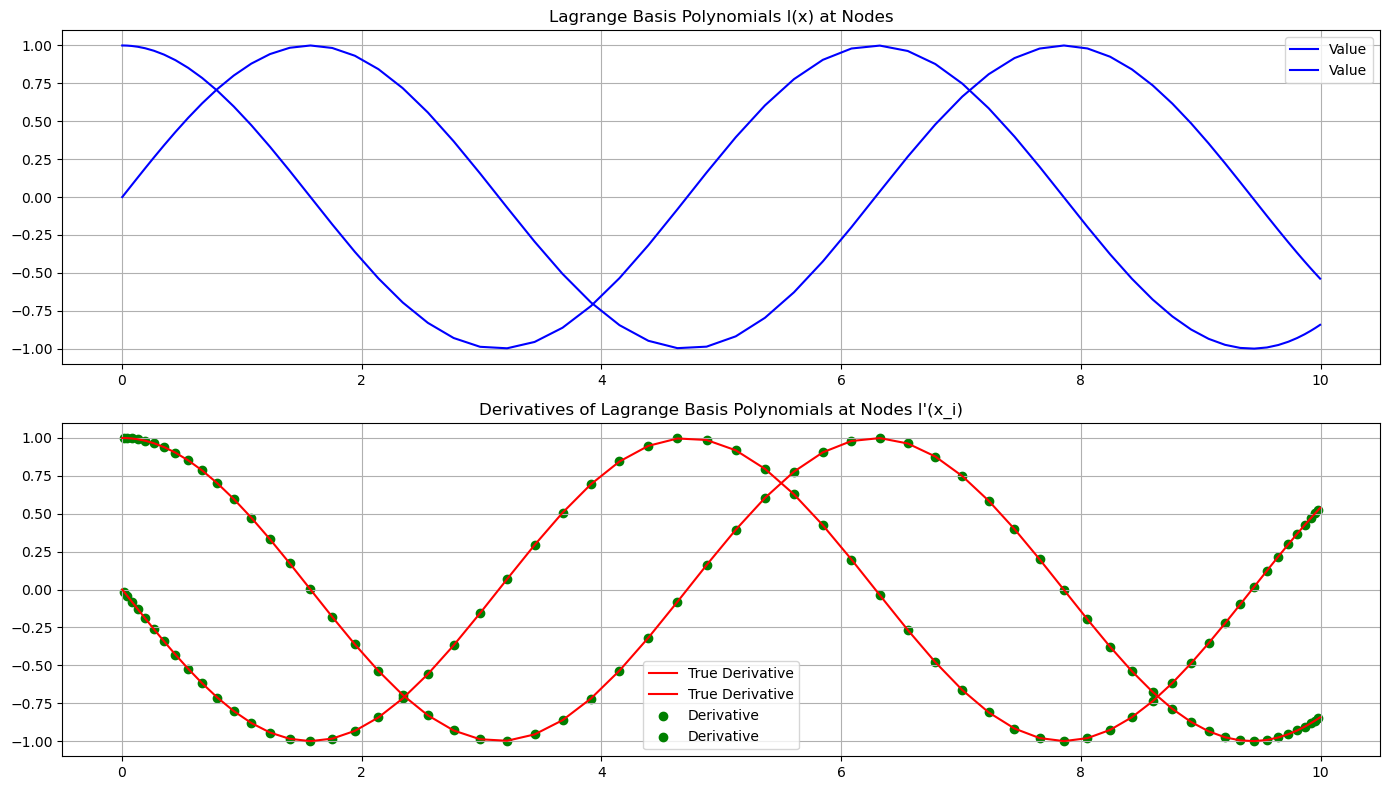

In [822]:
NODES = scaled_nodes
MATRIX = scaled_d_matrix

#---------------------------------------------DATA PARAMS---------------------------------------------#
N = q
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
start_time, end_time = a, b
start_time, end_time = min(nodes), max(nodes)
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state, t = NODES)

dy_dt_0 = []
dy_dt_1 = []

for i in range(0, len(MATRIX)):
    dy_dt_0.append(jnp.dot(MATRIX[:,:][i], y_ho[:,0]).item())
    dy_dt_1.append(jnp.dot(MATRIX[:,:][i], y_ho[:,1]).item())
    
    
k = 1
L, R = k, -k

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t_ho, y_ho, color='blue', label=f'Value')
plt.title('Lagrange Basis Polynomials l(x) at Nodes')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_ho, true_derivatives_ho, color='red', label = 'True Derivative')
plt.scatter(t_ho[L:R], dy_dt_1[L:R], color='green', label = 'Derivative')
plt.scatter(t_ho[L:R], dy_dt_0[L:R], color='green', label = 'Derivative')
plt.title("Derivatives of Lagrange Basis Polynomials at Nodes l'(x_i)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [765]:
error_norm = np.linalg.norm(true_derivatives_ho[:,0] - np.array(dy_dt_0))*0.5
error_norm += np.linalg.norm(true_derivatives_ho[:,1] - np.array(dy_dt_1))*0.5
print("Error Norm:", error_norm)

errors['GL_scipy'] = error_norm

Error Norm: 1.6418372590642515e-06


In [766]:
errors

{'chebyshev': 4.1509155355744796e-07, 'GL_scipy': 1.6418372590642515e-06}

----

In [789]:
def legendre_poly(n, x):
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return x
    else:
        P0 = np.ones_like(x)
        P1 = x
        for k in range(2, n + 1):
            Pk = ((2 * k - 1) * x * P1 - (k - 1) * P0) / k
            P0, P1 = P1, Pk
        return Pk

def legendre_poly_deriv(n, x):
    Pn = legendre_poly(n, x)
    Pn_minus_1 = legendre_poly(n-1, x)
    return n / (x**2 - 1) * (x * Pn - Pn_minus_1)

def newton_raphson(f, df, x0, tol=1e-10, max_iter=5000):
    x = x0
    for _ in range(max_iter):
        fx = f(x)
        dfx = df(x)
        if abs(fx) < tol:
            return x
        x -= fx / dfx
    raise RuntimeError(f"Newton-Raphson did not converge after {max_iter} iterations")

def find_roots(n):
    roots = []
    for i in range(1, n + 1):
        x0 = np.cos(np.pi * (i - 0.25) / (n + 0.5))  # Initial guess
        root = newton_raphson(lambda x: legendre_poly(n, x), 
                              lambda x: legendre_poly_deriv(n, x), 
                              x0)
        roots.append(root)
    return np.array(roots)

def compute_weights(n, nodes):
    weights = []
    for node in nodes:
        dPn = legendre_poly_deriv(n, node)
        weight = 2 / ((1 - node**2) * dPn**2)
        weights.append(weight)
    return np.array(weights)

def generate_gl_nodes_and_weights(q):
    """
    Generate Gauss-Legendre nodes and weights, ensuring node -1 is included.
    """
    # Include -1 as the first node
    nodes = [-1]
    nodes = []
    
    # Find the remaining q-1 roots of the (q-1)-th Legendre polynomial
    remaining_roots = find_roots(q)
    nodes.extend(remaining_roots)
    
    # Ensure nodes are sorted for consistency
    nodes = np.sort(nodes)
    
    # Compute weights for all nodes
    # weights = compute_weights(q, nodes)
    
    return np.array(nodes) #, weights


In [797]:
find_roots(q)

array([ 0.99930504,  0.99634012,  0.99101337,  0.98333625,  0.97332683,
        0.9610088 ,  0.94641137,  0.92956917,  0.91052214,  0.88931545,
        0.8659994 ,  0.8406293 ,  0.81326532,  0.78397236,  0.75281991,
        0.71988185,  0.68523631,  0.64896547,  0.61115536,  0.57189565,
        0.53127946,  0.48940315,  0.44636602,  0.40227016,  0.35722016,
        0.31132287,  0.26468716,  0.21742364,  0.16964442,  0.12146282,
        0.07299312,  0.02435029, -0.02435029, -0.07299312, -0.12146282,
       -0.16964442, -0.21742364, -0.26468716, -0.31132287, -0.35722016,
       -0.40227016, -0.44636602, -0.48940315, -0.53127946, -0.57189565,
       -0.61115536, -0.64896547, -0.68523631, -0.71988185, -0.75281991,
       -0.78397236, -0.81326532, -0.8406293 , -0.8659994 , -0.88931545,
       -0.91052214, -0.92956917, -0.94641137, -0.9610088 , -0.97332683,
       -0.98333625, -0.99101337, -0.99634012, -0.99930504])

In [790]:
# Example usage
q = 64  # Number of nodes
nodes = generate_gl_nodes_and_weights(q)
print("Gauss-Legendre Nodes:", nodes)
#print("Gauss-Legendre Weights:", weights)

Gauss-Legendre Nodes: [-0.99930504 -0.99634012 -0.99101337 -0.98333625 -0.97332683 -0.9610088
 -0.94641137 -0.92956917 -0.91052214 -0.88931545 -0.8659994  -0.8406293
 -0.81326532 -0.78397236 -0.75281991 -0.71988185 -0.68523631 -0.64896547
 -0.61115536 -0.57189565 -0.53127946 -0.48940315 -0.44636602 -0.40227016
 -0.35722016 -0.31132287 -0.26468716 -0.21742364 -0.16964442 -0.12146282
 -0.07299312 -0.02435029  0.02435029  0.07299312  0.12146282  0.16964442
  0.21742364  0.26468716  0.31132287  0.35722016  0.40227016  0.44636602
  0.48940315  0.53127946  0.57189565  0.61115536  0.64896547  0.68523631
  0.71988185  0.75281991  0.78397236  0.81326532  0.8406293   0.8659994
  0.88931545  0.91052214  0.92956917  0.94641137  0.9610088   0.97332683
  0.98333625  0.99101337  0.99634012  0.99930504]


In [791]:
def compute_differentiation_matrix(q, nodes):
    Lq_prime_values = legendre_poly_deriv(q, nodes)
    d_matrix = np.zeros((q, q))
    
    for i in range(q):
        for j in range(q):
            if i != j:
                d_matrix[i, j] = Lq_prime_values[i] / (Lq_prime_values[j] * (nodes[i] - nodes[j]))
            else:
                d_matrix[i, j] = nodes[i] / (1 - nodes[i]**2)
    
    return d_matrix

def scale_nodes(nodes, a, b):
    # Scale the nodes from [-1, 1] to [a, b]
    return 0.5 * (b - a) * (nodes + 1) + a

def compute_scaled_differentiation_matrix(q, nodes, a, b):
    # Compute the differentiation matrix for scaled nodes
    scaled_nodes = scale_nodes(nodes, a, b)
    d_matrix = compute_differentiation_matrix(q, nodes)
    
    # Adjust the differentiation matrix for the scaling
    scaling_factor = 2 / (b - a)
    scaled_d_matrix = d_matrix * scaling_factor
    
    return scaled_d_matrix, scaled_nodes

In [792]:
legendre_poly_deriv(q, scaled_nodes)

array([-0.00000000e+00, -1.46850143e+00, -6.01437146e+00, -9.63894129e-01,
        4.31002042e+00, -3.24945134e+00, -3.12593385e+00,  4.83298662e+00,
        6.53443844e+00,  3.60079880e+00, -8.56526106e+00,  9.22412169e+00,
        9.21141616e+00, -4.34372439e+01,  1.46514341e+14,  8.40106601e+20,
        8.91622969e+25,  1.36470136e+30,  6.13111721e+33,  1.14397227e+37,
        1.08355920e+40,  5.92706470e+42,  2.04649712e+45,  4.75850544e+47,
        7.82532556e+49,  9.45684974e+51,  8.66059164e+53,  6.16357976e+55,
        3.48101703e+57,  1.58803644e+59,  5.94124308e+60,  1.84690651e+62,
        4.82528385e+63,  1.07020837e+65,  2.03298521e+66,  3.33385473e+67,
        4.75299498e+68,  5.92848533e+69,  6.50654493e+70,  6.31572488e+71,
        5.44737834e+72,  4.19259138e+73,  2.89055453e+74,  1.79146173e+75,
        1.00127106e+76,  5.06153487e+76,  2.32037178e+77,  9.67019516e+77,
        3.67181093e+78,  1.27283667e+79,  4.03564900e+79,  1.17227692e+80,
        3.12451461e+80,  

In [793]:
d_matrix = compute_differentiation_matrix(q, nodes)

a = 0
b = 10
scaled_d_matrix, scaled_nodes = compute_scaled_differentiation_matrix(q, nodes, a, b)

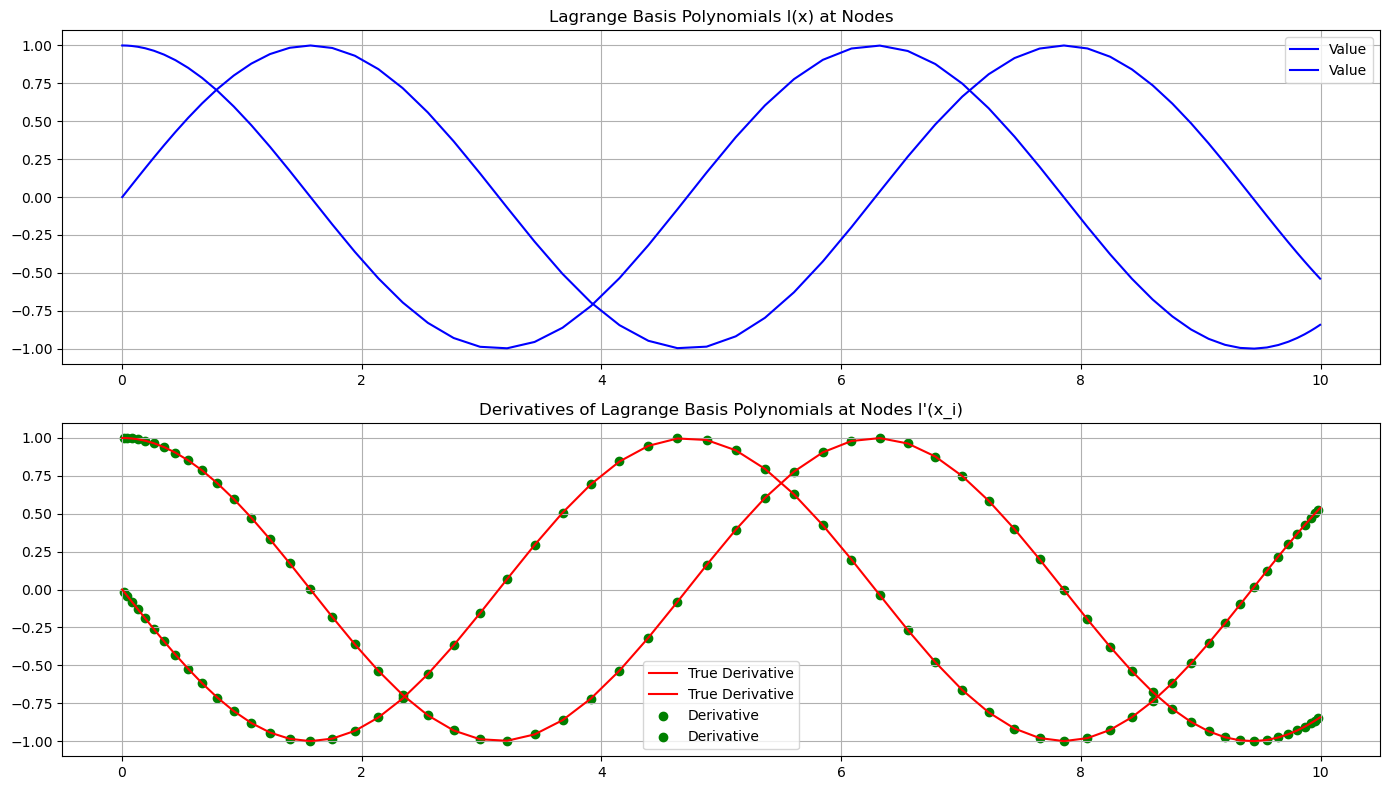

In [794]:
NODES = scaled_nodes
MATRIX = scaled_d_matrix

#---------------------------------------------DATA PARAMS---------------------------------------------#
N = q
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
start_time, end_time = a, b
start_time, end_time = min(nodes), max(nodes)
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state, t = NODES)

dy_dt_0 = []
dy_dt_1 = []

for i in range(0, len(MATRIX)):
    dy_dt_0.append(jnp.dot(MATRIX[:,][i], y_ho[:,0]).item())
    dy_dt_1.append(jnp.dot(MATRIX[:,][i], y_ho[:,1]).item())
    
    
k = 1
L, R = k, -k

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t_ho, y_ho, color='blue', label=f'Value')
plt.title('Lagrange Basis Polynomials l(x) at Nodes')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_ho, true_derivatives_ho, color='red', label = 'True Derivative')
plt.scatter(t_ho[L:R], dy_dt_1[L:R], color='green', label = 'Derivative')
plt.scatter(t_ho[L:R], dy_dt_0[L:R], color='green', label = 'Derivative')
plt.title("Derivatives of Lagrange Basis Polynomials at Nodes l'(x_i)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [796]:
t_ho

array([3.47479132e-03, 1.82994161e-02, 4.49331426e-02, 8.33187306e-02,
       1.33365861e-01, 1.94956002e-01, 2.67943126e-01, 3.52154139e-01,
       4.47389315e-01, 5.53422770e-01, 6.70003009e-01, 7.96853519e-01,
       9.33673424e-01, 1.08013821e+00, 1.23590046e+00, 1.40059075e+00,
       1.57381843e+00, 1.75517264e+00, 1.94422322e+00, 2.14052177e+00,
       2.34360268e+00, 2.55298427e+00, 2.76816991e+00, 2.98864921e+00,
       3.21389921e+00, 3.44338564e+00, 3.67656419e+00, 3.91288178e+00,
       4.15177790e+00, 4.39268590e+00, 4.63503439e+00, 4.87824854e+00,
       5.12175146e+00, 5.36496561e+00, 5.60731410e+00, 5.84822210e+00,
       6.08711822e+00, 6.32343581e+00, 6.55661436e+00, 6.78610079e+00,
       7.01135079e+00, 7.23183009e+00, 7.44701573e+00, 7.65639732e+00,
       7.85947823e+00, 8.05577678e+00, 8.24482736e+00, 8.42618157e+00,
       8.59940925e+00, 8.76409954e+00, 8.91986179e+00, 9.06632658e+00,
       9.20314648e+00, 9.32999699e+00, 9.44657723e+00, 9.55261069e+00,
      

In [795]:
np.linalg.norm(np.array(true_derivatives_ho[:,0]) - np.array(dy_dt_0))

1.2963401443541192e-06

In [716]:
error_norm = np.linalg.norm(true_derivatives_ho[:,0] - np.array(dy_dt_0))*0.5
error_norm += np.linalg.norm(true_derivatives_ho[:,1] - np.array(dy_dt_1))*0.5
print("Error Norm:", error_norm)

errors['GL'] = error_norm

Error Norm: 1.6406571607160582e-06


In [717]:
errors

{'chebyshev': 4.1509155355744796e-07,
 'GL_scipy': 1.6418372590642515e-06,
 'GL': 1.6406571607160582e-06}